In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata
import os
from IPython.display import display, Markdown, Latex
import random
import TileUtility

%matplotlib notebook

In [2]:
HT = TileUtility.HalfTiles(TileUtility.FullTiles())

In [3]:
# based on code from MP1 utils.py
def prompt_board_selection(image, count, title):
    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    fig.set_label(title)
    plt.axis('off')
    xs = []
    ys = []
    clicked = np.zeros((count, 2), dtype=np.float32)

    # Define a callback function that will update the textarea
    def onmousedown(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)

        plt.plot(xs, ys, 'r-+')

    def onmouseup(event):
        if(len(xs) >= count):
            plt.plot(xs ++ xs[0], ys ++ ys[0], 'r-+')
            plt.close(fig)

    def onclose(event):
        clicked[:, 0] = xs
        clicked[:, 1] = ys
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

In [4]:
# Zoom in where user clicked and let them adjust it.
def fineTunePoint(image, point):
    fig = plt.figure()
    
    Z = np.array([[point[0] - 50, point[1] - 50], [point[0] + 50, point[1] + 50]]).astype(int)
    plt.imshow(image[Z[0,1]:Z[1,1], Z[0,0]:Z[1,0]])
    plt.plot(50, 50, 'y-+')
    
    fig.set_label('Fine Tune Corner Selection')
    plt.axis('off')
    clicked = point
    hasClicked = False
    x = []
    y = []
    
    # Define a callback function that will update the textarea
    def onmousedown(event):
        x.append(event.xdata)
        y.append(event.ydata)
        hasClicked = True
        clicked[0] = x[0] + point[0] - 50
        clicked[1] = y[0] + point[1] - 50
        print("clicked is now {0}".format(clicked))
        plt.plot(x, y, 'r-+')

    def onmouseup(event):
        plt.plot(x, y, 'r-+')

    def onclose(event):
        pass
    
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

In [5]:
# My implementation of 4pt homography
#  This maps 4 points from origin onto a square 5*tile_res
# Getting this code to work was easy
# ..getting it to work fast was hard.

def fourPointExplodingHeartHomography(image, origin, tile_res):
    R = tile_res*5
    cx = [ p[0] for p in origin ]
    cy = [ p[1] for p in origin ]
    ix = [ 0, R, R, 0 ]
    iy = [ 0, 0, R, R ]

    # This setup follows 
    # http://www.cse.psu.edu/~rtc12/CSE486/lecture16.pdf
    T1 = np.array([
        [cx[0], cy[0], 1.,     0,     0,  0, -cx[0]*ix[0], -cy[0]*ix[0]],
        [    0,     0,  0, cx[0], cy[0],  1, -cx[0]*iy[0], -cy[0]*iy[0]],
        [cx[1], cy[1], 1.,     0,     0,  0, -cx[1]*ix[1], -cy[1]*ix[1]],
        [    0,     0,  0, cx[1], cy[1],  1, -cx[1]*iy[1], -cy[1]*iy[1]],
        [cx[2], cy[2], 1.,     0,     0,  0, -cx[2]*ix[2], -cy[2]*ix[2]],
        [    0,     0,  0, cx[2], cy[2],  1, -cx[2]*iy[2], -cy[2]*iy[2]],
        [cx[3], cy[3], 1.,     0,     0,  0, -cx[3]*ix[3], -cy[3]*ix[3]],
        [    0,     0,  0, cx[3], cy[3],  1, -cx[3]*iy[3], -cy[3]*iy[3]]])

    c1 = np.array([ix[0], iy[0], ix[1], iy[1], ix[2], iy[2], ix[3], iy[3]])
    est = np.linalg.solve(T1, c1)
    A = np.array([
        [est[0], est[1], est[2]],
        [est[3], est[4], est[5]],
        [est[6], est[7], 1.0]])
    Ainv = np.linalg.inv(A)

    # Maps origin onto target
    def regMap(xs, ys):
        txs = A[0, 0]*xs + A[0, 1]*ys + A[0, 2]
        tys = A[1, 0]*xs + A[1, 1]*ys + A[1, 2]
        hs = A[2, 0]*xs + A[2, 1]*ys + A[2, 2]
        txs = txs / hs
        tys = tys / hs
        return txs, tys

    # Maps target onto origin
    def invMap(xs, ys):
        txs = Ainv[0, 0]*xs + Ainv[0, 1]*ys + Ainv[0, 2]
        tys = Ainv[1, 0]*xs + Ainv[1, 1]*ys + Ainv[1, 2]
        hs = Ainv[2, 0]*xs + Ainv[2, 1]*ys + Ainv[2, 2]
        txs = txs / hs
        tys = tys / hs
        return txs, tys

    # The next few lines take pixel locations in the origin image within the boundaries
    #  and map them onto their target pixel.  It is expected that for a high resolution image
    #  this will happen a few dozen times for each target pixel.  Thus we just sum up the pixels
    #  landing here and divide by the number of hits later.
    old_grid_y, old_grid_x = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    target_xs, target_ys = regMap(old_grid_x, old_grid_y)
    txs = target_xs.astype('int32')
    tys = target_ys.astype('int32')

    sumpixel = np.zeros((R,R,3), 'int64')
    counts = np.zeros((R,R,3), 'int32')

    # The mask will be true when a given pixel location is in bounds
    mask = np.logical_and(np.logical_and(tys >= 0, tys < R),
                          np.logical_and(txs >= 0, txs < R))
    
    # This is a bit esoteric function I guess, but found this helpful comment on stackoverflow
    # https://stackoverflow.com/questions/46114340/numpy-advanced-indexing-same-index-used-multiple-times-in
    np.add.at(sumpixel, (tys[mask], txs[mask]), image[ old_grid_y[mask], old_grid_x[mask] ] )
    np.add.at(counts, (tys[mask], txs[mask]), 1 )
    
    result = (sumpixel / counts).astype('int')
    
    return {
        "image": result,
        "tile_res": tile_res,
        "regMap": regMap,
        "invMap": invMap,
        "A": A,
        "Ainv": Ainv
    }

In [6]:
# Takes a 5x5 array of terrains (0,1,2,3,4,5) and crowns (0, 1, 2, 3)
#  and returns score per kingdomino rules
#  size of each contiguous region as defined by orthogonal adjacency
#   times the number of crowns within that region
def scoreDomino(terrain, crowns):
    visited = np.zeros((5,5), 'uint8')
    score = []
    
    for I in range(25):
        i, j = I // 5, I % 5
    
        # If we haven't seen this tile yet and it's an actual tile
        # as opposed to the home tile or the table top
        if visited[i, j] == 0 and terrain[i, j] >= 0 and terrain[i, j] < 6:
            
            # Add to the queue
            queue = [(i, j)]
            T = terrain[i, j]
            C = 0  # Crowns
            N = 0  # Tiles

            # While the queue is not empty,
            #  tally up the crowns and add other adjacent tiles
            #  of the same terrain to the queue.
            current = []
            while len(queue) > 0:
                x, y = queue.pop(0)
                
                # This is needed because the same tile could be added by multiple
                # neighbors.  I can probably get rid of this with a rewrite..
                if visited[x, y] == 1: continue

                C = C + crowns[x, y]
                N = N + 1
                visited[x, y] = 1
                current.append((x,y))

                neighbors = [ (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1) ]
                for xx, yy in neighbors:
                    # Make the sure the tile is inbounds
                    if (xx < 0 or xx > 4 or yy < 0 or yy > 4): continue
                    # ...and it is the right terrain
                    if terrain[xx, yy] != T: continue
                    # ...and we haven't already visited it once
                    if visited[xx, yy] == 1: continue
                    queue.append((xx, yy))

            score.append({"tiles": current, "terrain": TileUtility.itot(T), "crowns": C, "numtiles": N, "total": C*N})
    return score

def prettyPrintScore(score, terrain, crowns):   
    row  = "| Region | Tiles | Crowns | Subtotal | Tiles |\n"
    row += "| ---    | ---:   | ---:    | ---: | :---  |\n"
    letters = "ABCDE"
    subtotal = 0
    for i, s in enumerate(score):
        subtotal += s["total"]
        row = row + "| " + s["terrain"] + " | " + str(s["numtiles"]) + " | " + str(s["crowns"])
        row = row + " | " + str(s["total"])  + " | "
        
        temp = ""
        for t in s["tiles"]:
            temp += letters[t[1]] + str(t[0]+1) + "!"*crowns[t[0], t[1]] + ","
        temp = temp[0:len(temp)-1]
        row = row + temp + " |\n"
    row += "| __Total__  | | | " + str(subtotal) + " | |\n"
    return row

#  Start Here!

<IPython.core.display.Javascript object>


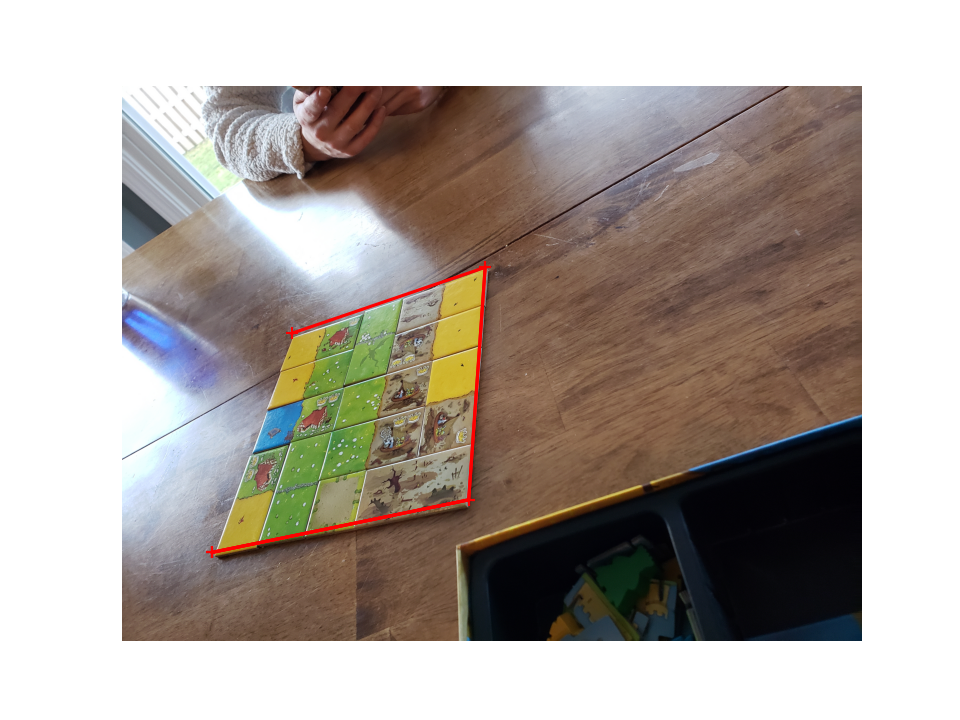

In [9]:
img = cv2.cvtColor(cv2.imread("dev_images/20201123_132903.jpg"), cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(cv2.imread("dev_images/20201123_134443.jpg"), cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(cv2.imread("dev_images/20201123_135943.jpg"), cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(cv2.imread("dev_images/20201102_193728.jpg"), cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(cv2.imread("dev_images/20201123_134449.jpg"), cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(cv2.imread("dev_images/20201102_195436.jpg"), cv2.COLOR_BGR2RGB)

points = prompt_board_selection(img, 4, "Click on corners of game board.")

In [10]:
points[0] = fineTunePoint(img, points[0])

<IPython.core.display.Javascript object>

In [11]:
points[1] = fineTunePoint(img, points[1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


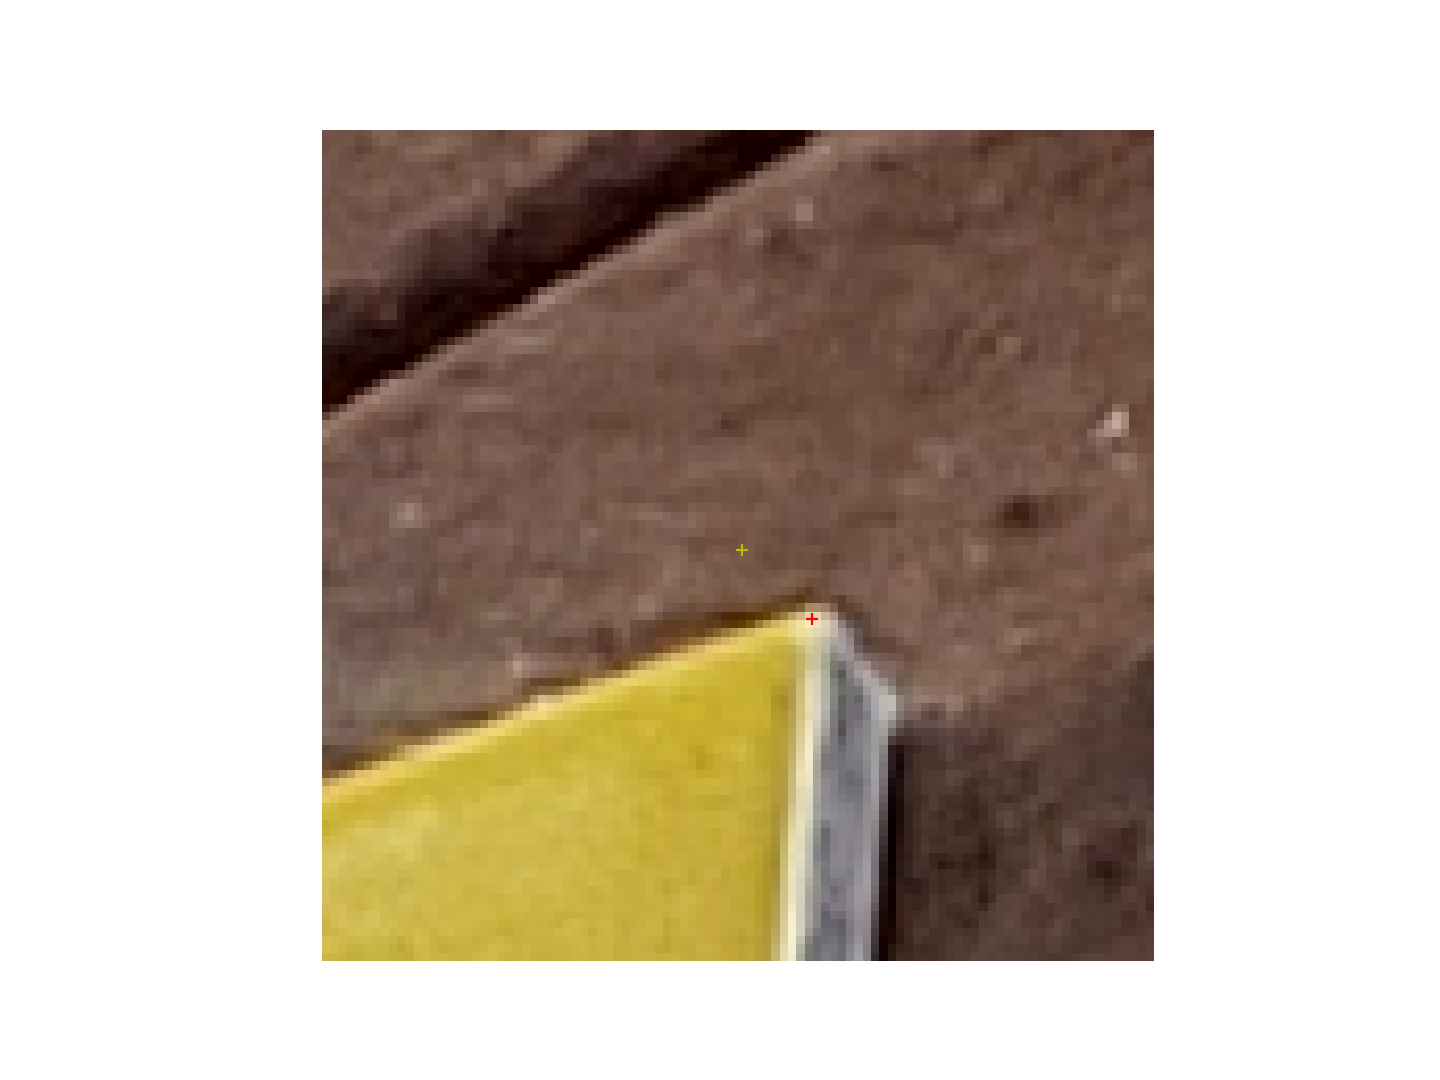

In [12]:
points[2] = fineTunePoint(img, points[2])

In [13]:
points[3] = fineTunePoint(img, points[3])

<IPython.core.display.Javascript object>

In [14]:
points

array([[ 502.4021 , 2561.6963 ],
       [1869.5665 , 2283.6697 ],
       [1986.7618 ,  994.90326],
       [ 932.7917 , 1369.7043 ]], dtype=float32)

<IPython.core.display.Javascript object>


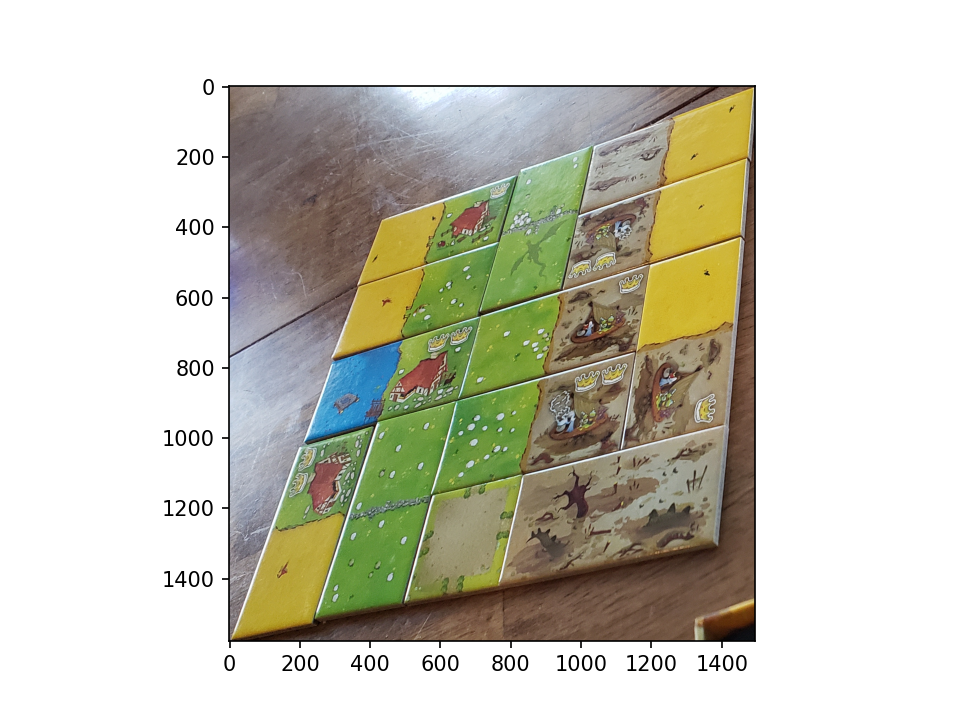

In [15]:
# Crop the image to enclose boundary
cropX = (int(np.min(points[:,0]))-5, 5+int(np.max(points[:,0])))
cropY = (int(np.min(points[:,1]))-5, 5+int(np.max(points[:,1])))

board = img.copy()
board = board[cropY[0]:cropY[1], cropX[0]:cropX[1]]
plt.figure()
plt.imshow(board)

points_cropped = [ [ x - cropX[0], y - cropY[0] ] for x, y in points ]

<IPython.core.display.Javascript object>


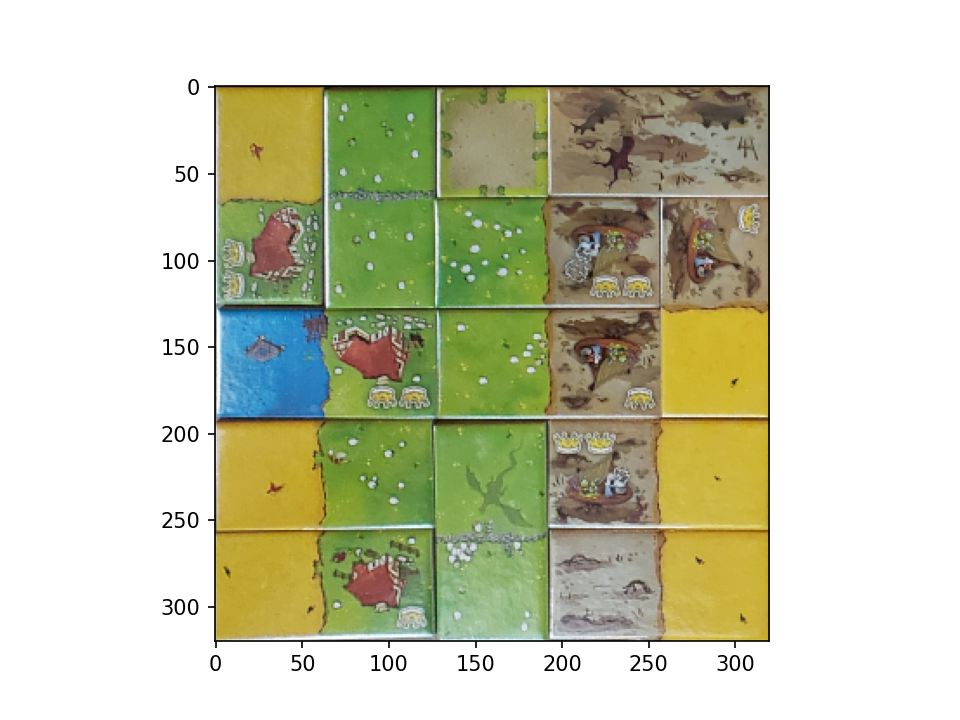

In [16]:
board_w = fourPointExplodingHeartHomography(board, points_cropped, 64)
plt.figure()
plt.imshow(board_w["image"])

In [17]:
terrain = np.zeros((5,5), 'uint8')
crowns = np.zeros((5,5), 'uint8')
tile_res = 64

tiles = board_w["image"] / 255.
test_bw = False

for i in range(5):
    for j in range(5):
        tile = tiles[tile_res*i:tile_res*(i+1), tile_res*j:tile_res*(j+1)]
        
        if test_bw:
            tile = cv2.cvtColor(tile.astype('float32'), cv2.COLOR_RGB2GRAY)
            terrain[i, j] = HT.predictTerrain_bw(tile)
            crowns[i, j] = HT.predictCrowns_bw(tile)
        else:
            terrain[i,j] = HT.predictTerrain(tile)
            crowns[i,j] = HT.predictCrowns(tile)
        
score = scoreDomino(terrain, crowns)
markdown = prettyPrintScore(score, terrain, crowns)
markdown = "# Score for Board\n" + markdown
display(Markdown(markdown))

# Score for Board
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A1 |
| grass | 10 | 5 | 50 | B1,B2,B3!!,A2!!,C2,B4,C3,B5!,C4,C5 |
| swamp | 7 | 6 | 42 | D1,D2!!,E1,D3!,E2!,D4!!,D5 |
| ocean | 1 | 0 | 0 | A3 |
| desert | 3 | 0 | 0 | E3,E4,E5 |
| desert | 2 | 0 | 0 | A4,A5 |
| __Total__  | | | 92 | |


# Cheat!  
Replace a domino on your board with any of the available dominos.  First, we are going to reconstruct the game board with similar tiles so that we can do a better job color matching.


<IPython.core.display.Javascript object>


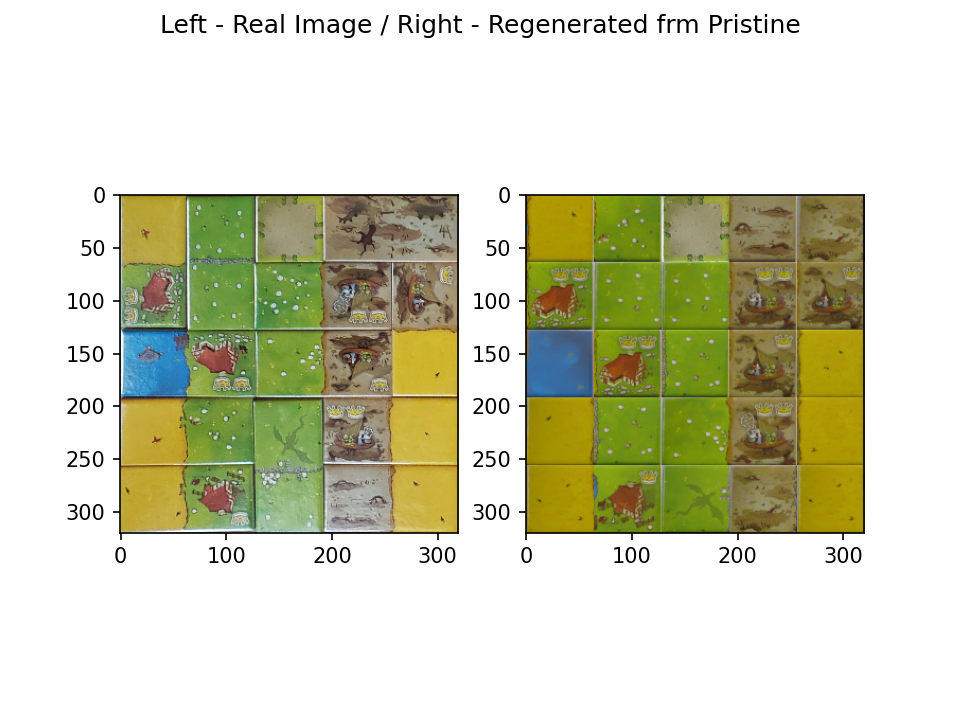

In [18]:
pristine_board = np.zeros(tiles.shape)
for i in range(5):
    for j in range(5):
        candidates = list(HT.tileCandidates2(terrain[i, j], crowns[i, j]))
        if len(candidates) == 0:
            #print("Cant find image for {0}. using source image intead".format((terrain[i, j], crowns[i, j])))
            image = tiles[tile_res*i:tile_res*(i+1), tile_res*j:tile_res*(j+1)].copy()
        else:
            rc = random.choice(candidates)
            #print(rc)
            image = HT.returnHalfImage(rc[0], rc[1])["image"]
            image = cv2.resize(image, (tile_res, tile_res))
            image = image / 255.
        pristine_board[tile_res*i:tile_res*(i+1), tile_res*j:tile_res*(j+1)] = image.copy()


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Left - Real Image / Right - Regenerated frm Pristine')
ax1.imshow(tiles)
ax2.imshow(pristine_board)

In [19]:
orig = tiles.copy()
orig = cv2.cvtColor(orig.astype('float32'), cv2.COLOR_RGB2Lab)

prist = pristine_board.copy()
prist = cv2.cvtColor(pristine_board.astype('float32'), cv2.COLOR_RGB2Lab)

chan = 0
scale = np.mean(orig, axis=(0, 1)) / np.mean(prist, axis = (0, 1))
scale[1] = 1
scale[2] = 1
prist = prist * scale
prist2 = cv2.cvtColor(prist, cv2.COLOR_Lab2RGB)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Left - Pristine / Right - Color Adjusted')
ax1.imshow(pristine_board)
ax2.imshow(prist2)

<IPython.core.display.Javascript object>

## Pick the top-left domino you want to replace.

<IPython.core.display.Javascript object>


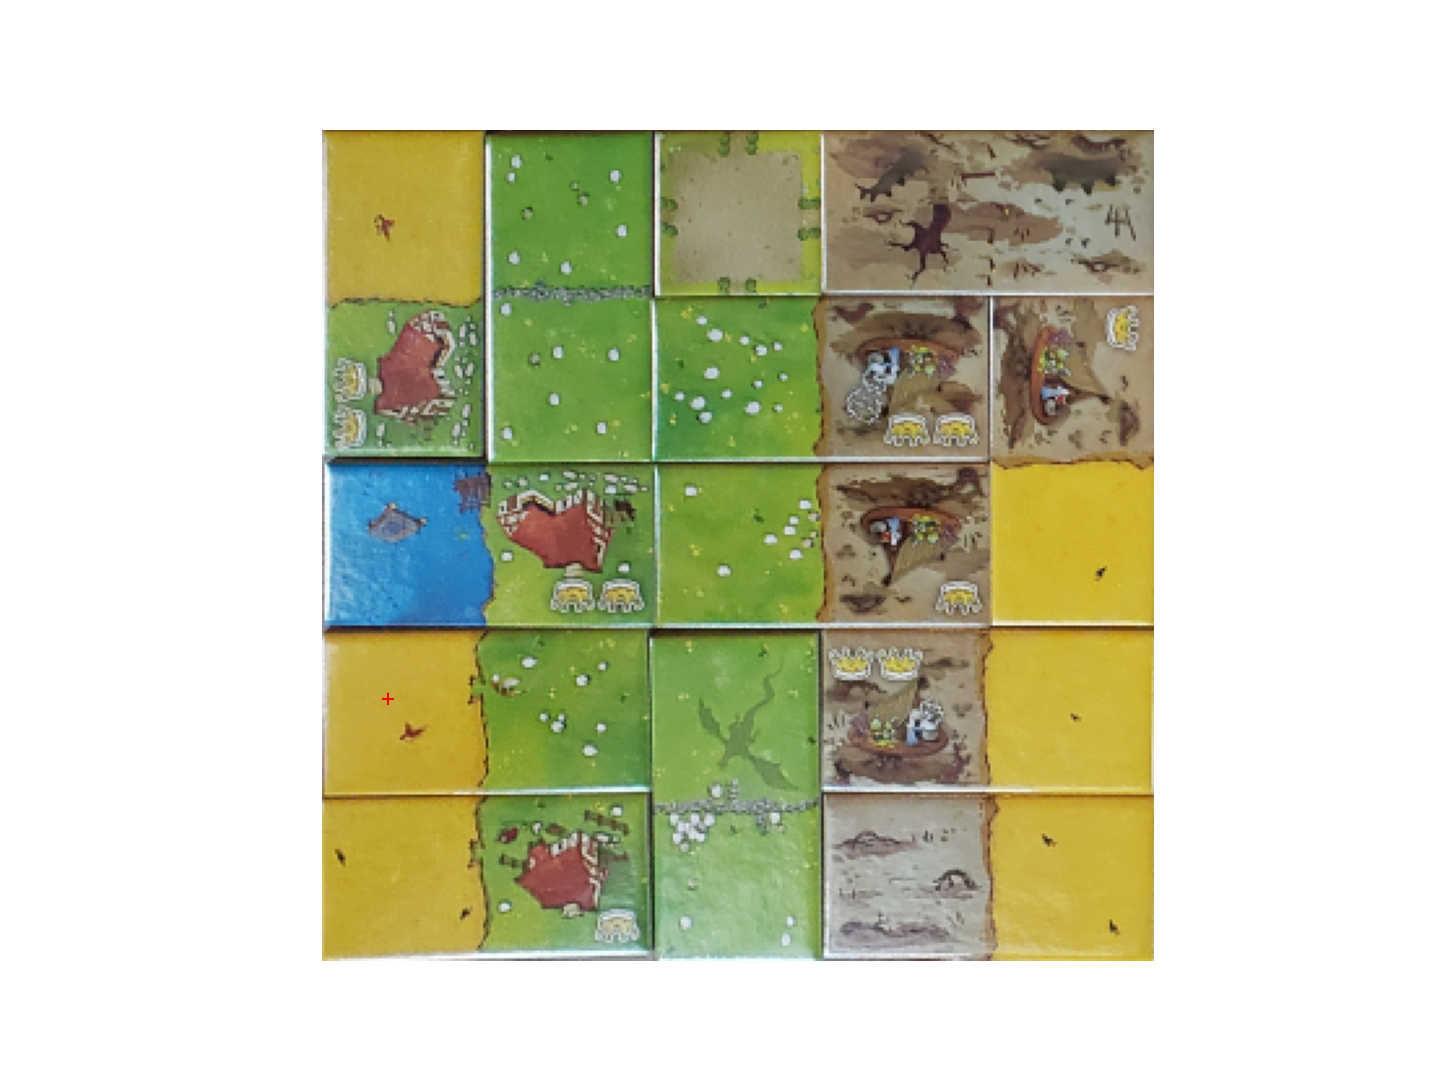

In [20]:
whichDominos = prompt_board_selection(tiles, 1, "Pick top-left tile to replace")

In [21]:
whichDominos = np.floor(whichDominos / tile_res).astype('int')

In [22]:
# Build up a grid of the pristine domino pictures and have user select one.
# Since there are 48, each of which are 1x2, we'll show them in a 10x10 grid
bigGrid = np.zeros((10*tile_res, 10*tile_res, 3), 'int')
locations = { }
filenames = { }

ctr = 0
for domino in os.listdir("processed_tiles/"):
    if domino == "cropped_crown.png" or domino == "cropped_crown_mask.png": continue
    tile = domino.split("_")[2]
    
    origDomino = cv2.cvtColor(cv2.imread("processed_tiles/" + domino), cv2.COLOR_BGR2RGB)
    temp = cv2.resize(origDomino, (tile_res*2, tile_res))
    row = ctr // 5
    col = 2*(ctr % 5)
    ctr = ctr + 1
    bigGrid[row*tile_res:(row+1)*tile_res, col*tile_res:(col+2)*tile_res] = temp
    locations[(row, col)]     = temp[0:tile_res, 0:tile_res].copy()
    locations[(row, col + 1)] = temp[0:tile_res, tile_res:(2*tile_res)].copy()

replaceDominos = prompt_board_selection(bigGrid, 2, "Pick two tiles to replace domino")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


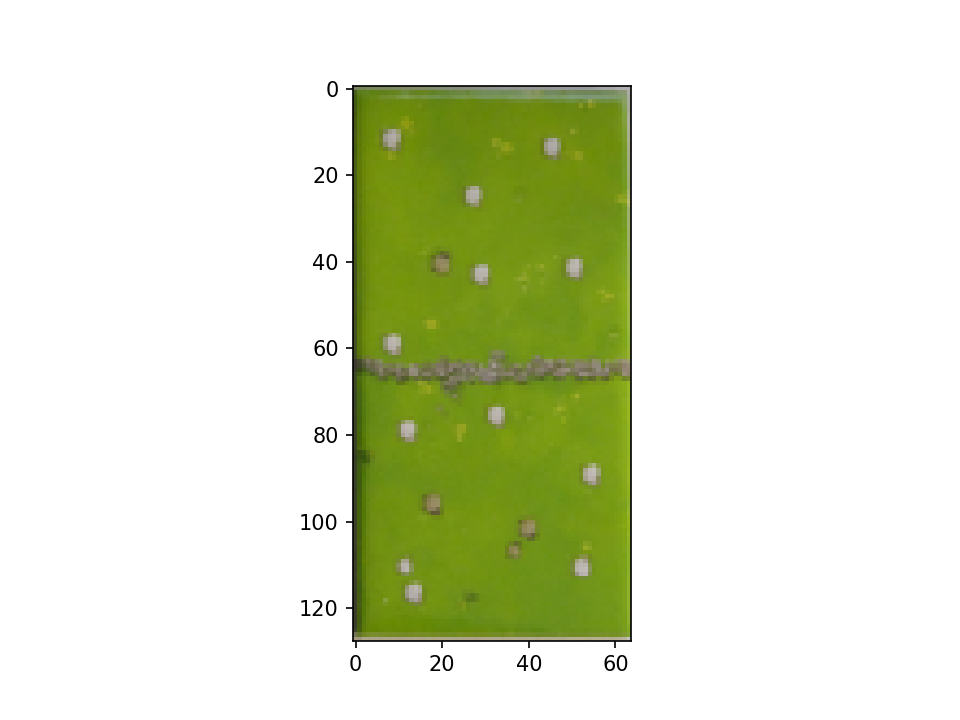

In [23]:
t = np.floor(replaceDominos // tile_res).astype('int')

new_domino = np.zeros((tile_res, 2*tile_res, 3))
new_domino[0:tile_res, 0:tile_res] = locations[(t[0][1], t[0][0])] / 255.
new_domino[0:tile_res, tile_res:tile_res*2] = locations[(t[1][1], t[1][0])] / 255.

# Note to TA - Comment out one
#orientation = None
orientation = cv2.ROTATE_90_CLOCKWISE
#orientation = cv2.ROTATE_180
#orientation = cv2.ROTATE_90_COUNTERCLOCKWISE

#Rotate?
if orientation == None: pass
else: new_domino = cv2.rotate(new_domino, orientation)
    
plt.figure()
plt.imshow(new_domino)

<IPython.core.display.Javascript object>


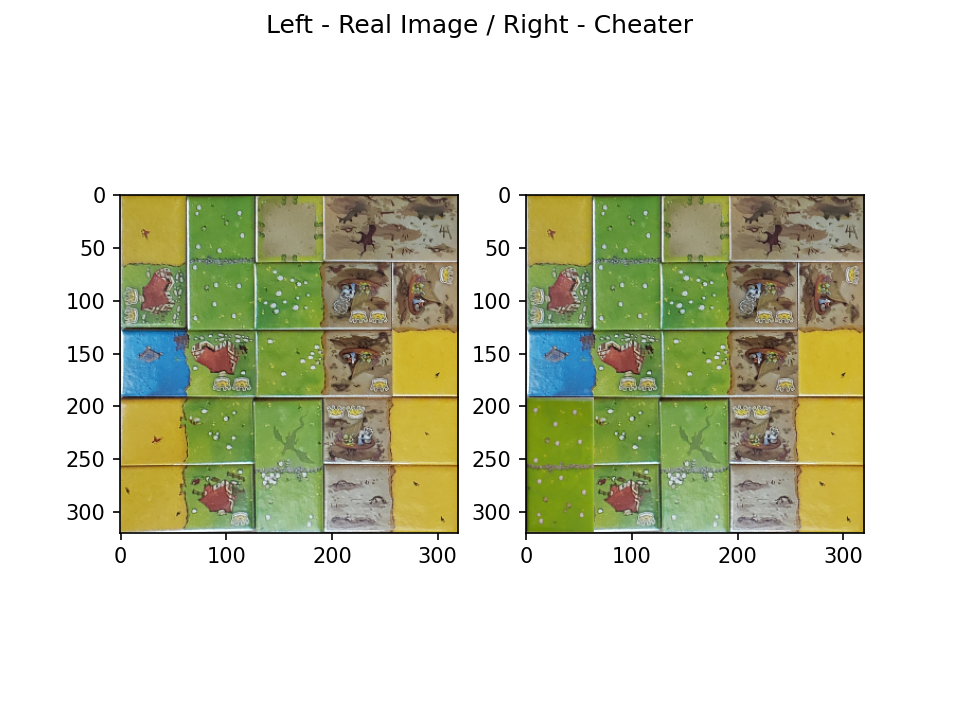

In [24]:
# Use the color adjustment calculated above on this new domino and insert into the game board.
new_domino_lab = cv2.cvtColor(new_domino.astype('float32'), cv2.COLOR_RGB2Lab)
new_domino_lab = new_domino_lab + scale
new_domino = cv2.cvtColor(new_domino_lab, cv2.COLOR_Lab2RGB)

cheat_tiles = tiles.copy()
size = np.array(new_domino.shape) // tile_res

ystart, ystop = tile_res*whichDominos[0][1], tile_res*(whichDominos[0][1] + size[0])
xstart, xstop = tile_res*whichDominos[0][0], tile_res*(whichDominos[0][0] + size[1])

cheat_tiles[ ystart:ystop, xstart:xstop ] = new_domino.copy()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Left - Real Image / Right - Cheater')
ax1.imshow(tiles)
ax2.imshow(cheat_tiles)

In [25]:
point_x = np.array([xstart, xstart, xstop, xstop])
point_y = np.array([ystart, ystop,  ystop, ystart])
map_x, map_y = board_w["invMap"](point_x, point_y)
points = np.zeros((4, 1, 2))
points[:, 0, 0] = map_x
points[:, 0, 1] = map_y

mask = np.zeros(board.shape[0:2])
mask = cv2.fillConvexPoly(mask, points.astype('int32'), (1, 1, 1))
mask = (mask > 0)

# Before we do the inverse map, we want to upscale the domino a few times
# otherwise this naive method of perspective transformatin won't be dense
#  and we'll have a bunch of holes in the target image.

pixels_in_mask = np.sum(mask)
# We know that in a perfect rectangle 2L^2 = pixels_in_mask, so we'll 
# air on side of caution and say we need our origin resolution
#  to be at least 2L
L = np.sqrt(pixels_in_mask / 2.)
L = int(2*L) 

# Find the smallest integer such >= (new_res / tile_res)
s = int(L / tile_res) + 1

print("pixels in mask {0}\nL {1}\nscale {2}".format(pixels_in_mask, L, s))
cheat_tiles_upres = cv2.resize(cheat_tiles, None, fx=s, fy=s, interpolation = cv2.INTER_CUBIC)
print("cheat_tiles_upres shape {0}".format(cheat_tiles_upres.shape))

# cv2.resize apparently can move things out of range...
cheat_tiles_upres = np.clip(cheat_tiles_upres, 0, 1)

invMap = board_w["invMap"]
# The next few lines take pixel locations in the origin image within the boundaries
#  and map them onto their target pixel.  It is expected that for a high resolution image
#  this will happen a few dozen times for each target pixel.  Thus we just sum up the pixels
#  landing here and divide by the number of hits later.
new_grid_y, new_grid_x = np.mgrid[s*ystart:s*ystop, s*xstart:s*xstop]
target_xs, target_ys = invMap(new_grid_x/s, new_grid_y/s)
txs = target_xs.astype('int32')
tys = target_ys.astype('int32')

reproj = np.zeros(board.shape)
counts = np.zeros(reproj.shape, 'int32')

# The mask will be true when a given pixel location is in bounds
#mask = np.logical_and(np.logical_and(tys >= 0, tys < R),
#                      np.logical_and(txs >= 0, txs < R))

# This is a bit esoteric function I guess, but found this helpful comment on stackoverflow
# https://stackoverflow.com/questions/46114340/numpy-advanced-indexing-same-index-used-multiple-times-in
np.add.at(reproj, (tys, txs), cheat_tiles_upres[ new_grid_y, new_grid_x ] )
np.add.at(counts, (tys, txs), 1 )
counts[counts == 0] = 1

result = reproj / counts
plt.figure()
plt.imshow(result)

pixels in mask 71152
L 377
scale 6
cheat_tiles_upres shape (1920, 1920, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


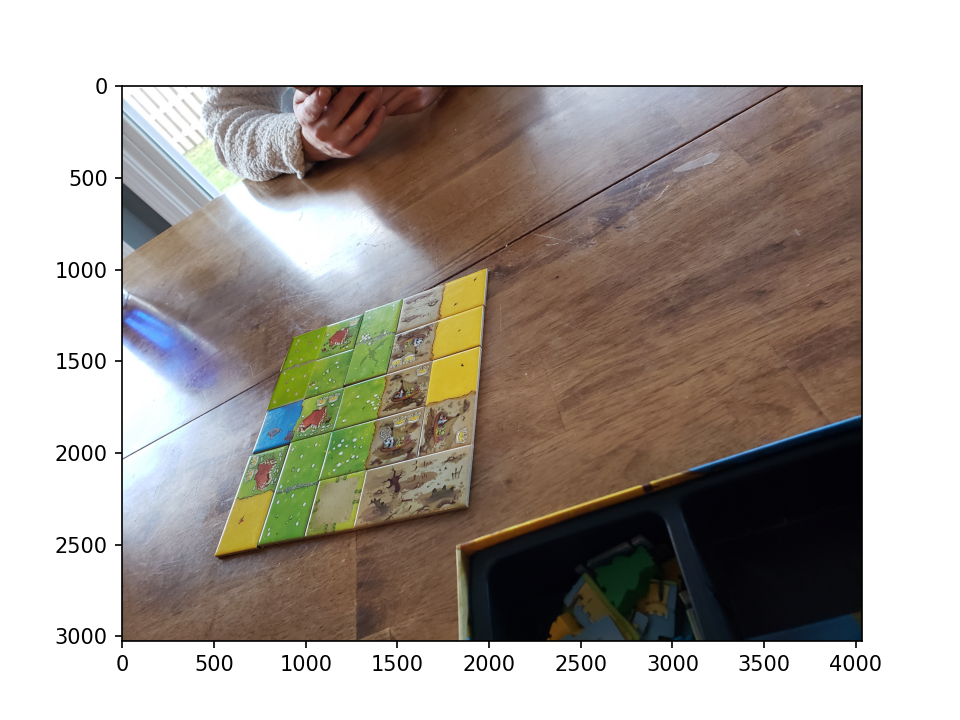

In [26]:
board_cheat = board.copy()
result_int = (255*result).astype('uint8')
for c in range(3):
    board_cheat[:,:,c] = mask*result_int[:,:,c] + (1 - mask)*board[:,:,c]

img_cheat = img.copy()
img_cheat[cropY[0]:cropY[1], cropX[0]:cropX[1]] = board_cheat
plt.figure()
plt.imshow(img_cheat)

<IPython.core.display.Javascript object>


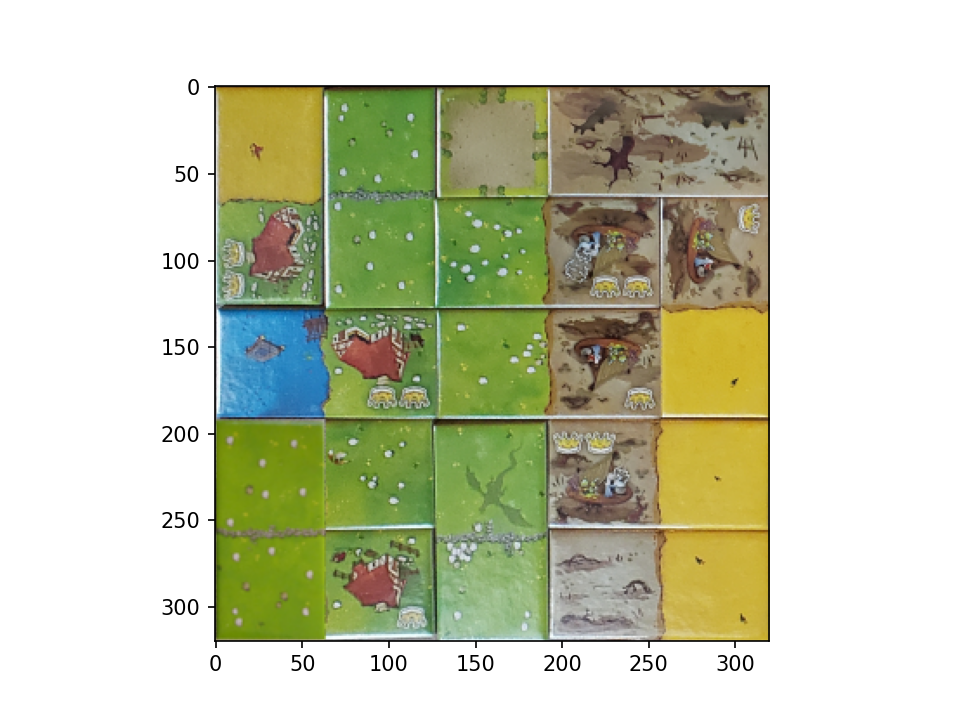

# Score for Board
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A1 |
| grass | 12 | 5 | 60 | B1,B2,B3!!,A2!!,C2,B4,C3,B5!,A4,C4,A5,C5 |
| swamp | 7 | 6 | 42 | D1,D2!!,E1,D3!,E2!,D4!!,D5 |
| ocean | 1 | 0 | 0 | A3 |
| desert | 3 | 0 | 0 | E3,E4,E5 |
| __Total__  | | | 102 | |


In [27]:
board_cheat_w = fourPointExplodingHeartHomography(board_cheat, points_cropped, 64)
plt.figure()
plt.imshow(board_cheat_w["image"])

terrain = np.zeros((5,5), 'uint8')
crowns = np.zeros((5,5), 'uint8')
tile_res = 64

tiles_w = board_cheat_w["image"] / 255.


for i in range(5):
    for j in range(5):
        tile = tiles_w[tile_res*i:tile_res*(i+1), tile_res*j:tile_res*(j+1)]
        terrain[i,j] = HT.predictTerrain(tile)
        crowns[i,j] = HT.predictCrowns(tile)
        
score = scoreDomino(terrain, crowns)
markdown = prettyPrintScore(score, terrain, crowns)
markdown = "# Score for Board\n" + markdown
display(Markdown(markdown))